In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt

from base_rl.eval_policy import EvalDiscreteStatePolicy
from dynamic_programming.mdp_model import MDPModel
from dynamic_programming.policy import DPPolicy
from envs.env_creator import env_creator
from envs.plot import plot_industrial_benchmark_trajectories

In [2]:
plt.rcParams["figure.figsize"] = [20, 12]

## Load Data and MDP Model

In [3]:
#trajectories_samples = ['trajectory_ep1000_model_aeq-20bits2.npy', 'trajectory_ep1000_model_final_h20bits3.npy', 'trajectory_ep1000_model_h_c-20bits3.npy']
trajectories_samples = ['trajectory_ep1000_model_final_h20bits3.npy']


device = 'cpu'
mdp_save_paths = [f'tmp/duipi/mdp_{file.split(".")[0]}.pkl' for file in trajectories_samples]
model_names = [''.join(file.split(".")[0].split('ep')[-1].split('_', maxsplit=1)[-1]) for file in trajectories_samples]
quant_models_paths = [f'tmp/state_quantization/{model_name}' for model_name in model_names]
policies_save_paths = [f'tmp/duipi/ib_policy_{file.split(".")[0]}.pkl' for file in trajectories_samples]

## Create MDP Models

In [4]:
from dynamic_programming.mdp_model import create_mdp_models

for i, sample_file in enumerate(trajectories_samples):
    load_path = os.path.join("tmp", "offline_rl_trajectories", sample_file)
    create_mdp_models(load_path=load_path, mdp_save_path=mdp_save_paths[i], reward_function_type='state_action_state', device=device, calc_reward_variance=True,reward_offset=2000)

tmp/duipi/mdp_trajectory_ep1000_model_final_h20bits3.pkl
-343.5118262206573
1000000
1126
Computing Transition Model


KeyboardInterrupt: 

In [15]:
from duipi.train import DUIPITrainer

for i, mdp_save_path in enumerate(mdp_save_paths):
    print(trajectories_samples[i])
    mdp_model = MDPModel.load(mdp_save_path)
    solver = DUIPITrainer(reward_function=mdp_model.reward_function, transition_model=mdp_model.transition_model,
                         count_state_action=mdp_model.count_state_action, xi=-0.1, gamma=0.995, variance_R=mdp_model.reward_variance,count_state_action_state=mdp_model.count_state_action_state, bayesian=True, alpha_prior=0.9)
    solver.train(epochs=1000)
    trained_policy = DPPolicy(policy_table=solver.get_policy(), state_to_index=mdp_model.state_to_index,
                              index_to_action=mdp_model.index_to_actions)
    trained_policy.save(policies_save_paths[i])

trajectory_ep1000_model_final_h20bits3.npy
Epoch: 1
Old vs New policy difference: 128003.53110189251
Epoch: 2
Old vs New policy difference: 122064.87166505537
Epoch: 3
Old vs New policy difference: 120280.20936130374
Epoch: 4
Old vs New policy difference: 119247.34613831509
Epoch: 5
Old vs New policy difference: 118450.96801699317
Epoch: 6
Old vs New policy difference: 117789.03834283807
Epoch: 7
Old vs New policy difference: 117138.58388621295
Epoch: 8
Old vs New policy difference: 116543.0365523764
Epoch: 9
Old vs New policy difference: 115926.69828358885
Epoch: 10
Old vs New policy difference: 115358.26340027648
Epoch: 11
Old vs New policy difference: 114761.97624153265
Epoch: 12
Old vs New policy difference: 114200.63479608114
Epoch: 13
Old vs New policy difference: 113623.86274656486
Epoch: 14
Old vs New policy difference: 113061.75041340484
Epoch: 15
Old vs New policy difference: 112484.58373059565
Epoch: 16
Old vs New policy difference: 111934.20155461585
Epoch: 17
Old vs New po

Tag: ib_policy_trajectory_ep1000_model_final_h20bits3
Episode 9 Reward: -223.65478859200337 || New State Found: False


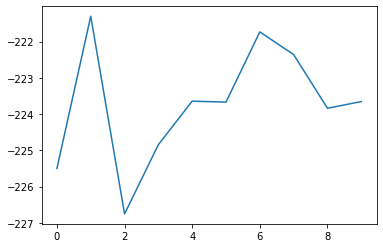

Reward Mean: -223.7296703968002
Reward std : 1.5917138130515431


In [16]:
from benchmarks.policy_benchmarks import PolicyBenchmarks

steps_per_episode = 1000
evaluators = []
for i, policy_file in enumerate(policies_save_paths):
    eval_policy = DPPolicy.load(policy_file)
    env_kwargs = {'steps_per_episode': steps_per_episode, 'device': device, 'model_path': quant_models_paths[i]}
    evaluator = EvalDiscreteStatePolicy(policy=eval_policy, env_creator=env_creator, env_kwargs=env_kwargs,
                                        tag=policy_file.split('/')[-1].split('.')[0])
    evaluators.append(evaluator)

policy_benchmarks = PolicyBenchmarks(evaluators=evaluators, epochs=10)
policy_benchmarks.benchmark()

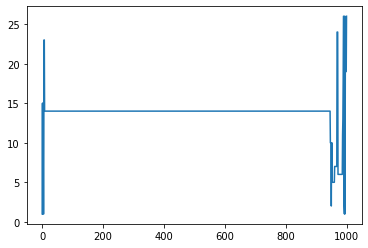

In [17]:
plt.plot(policy_benchmarks.evaluators[-1].eval_trajectories[-2]['actions'])

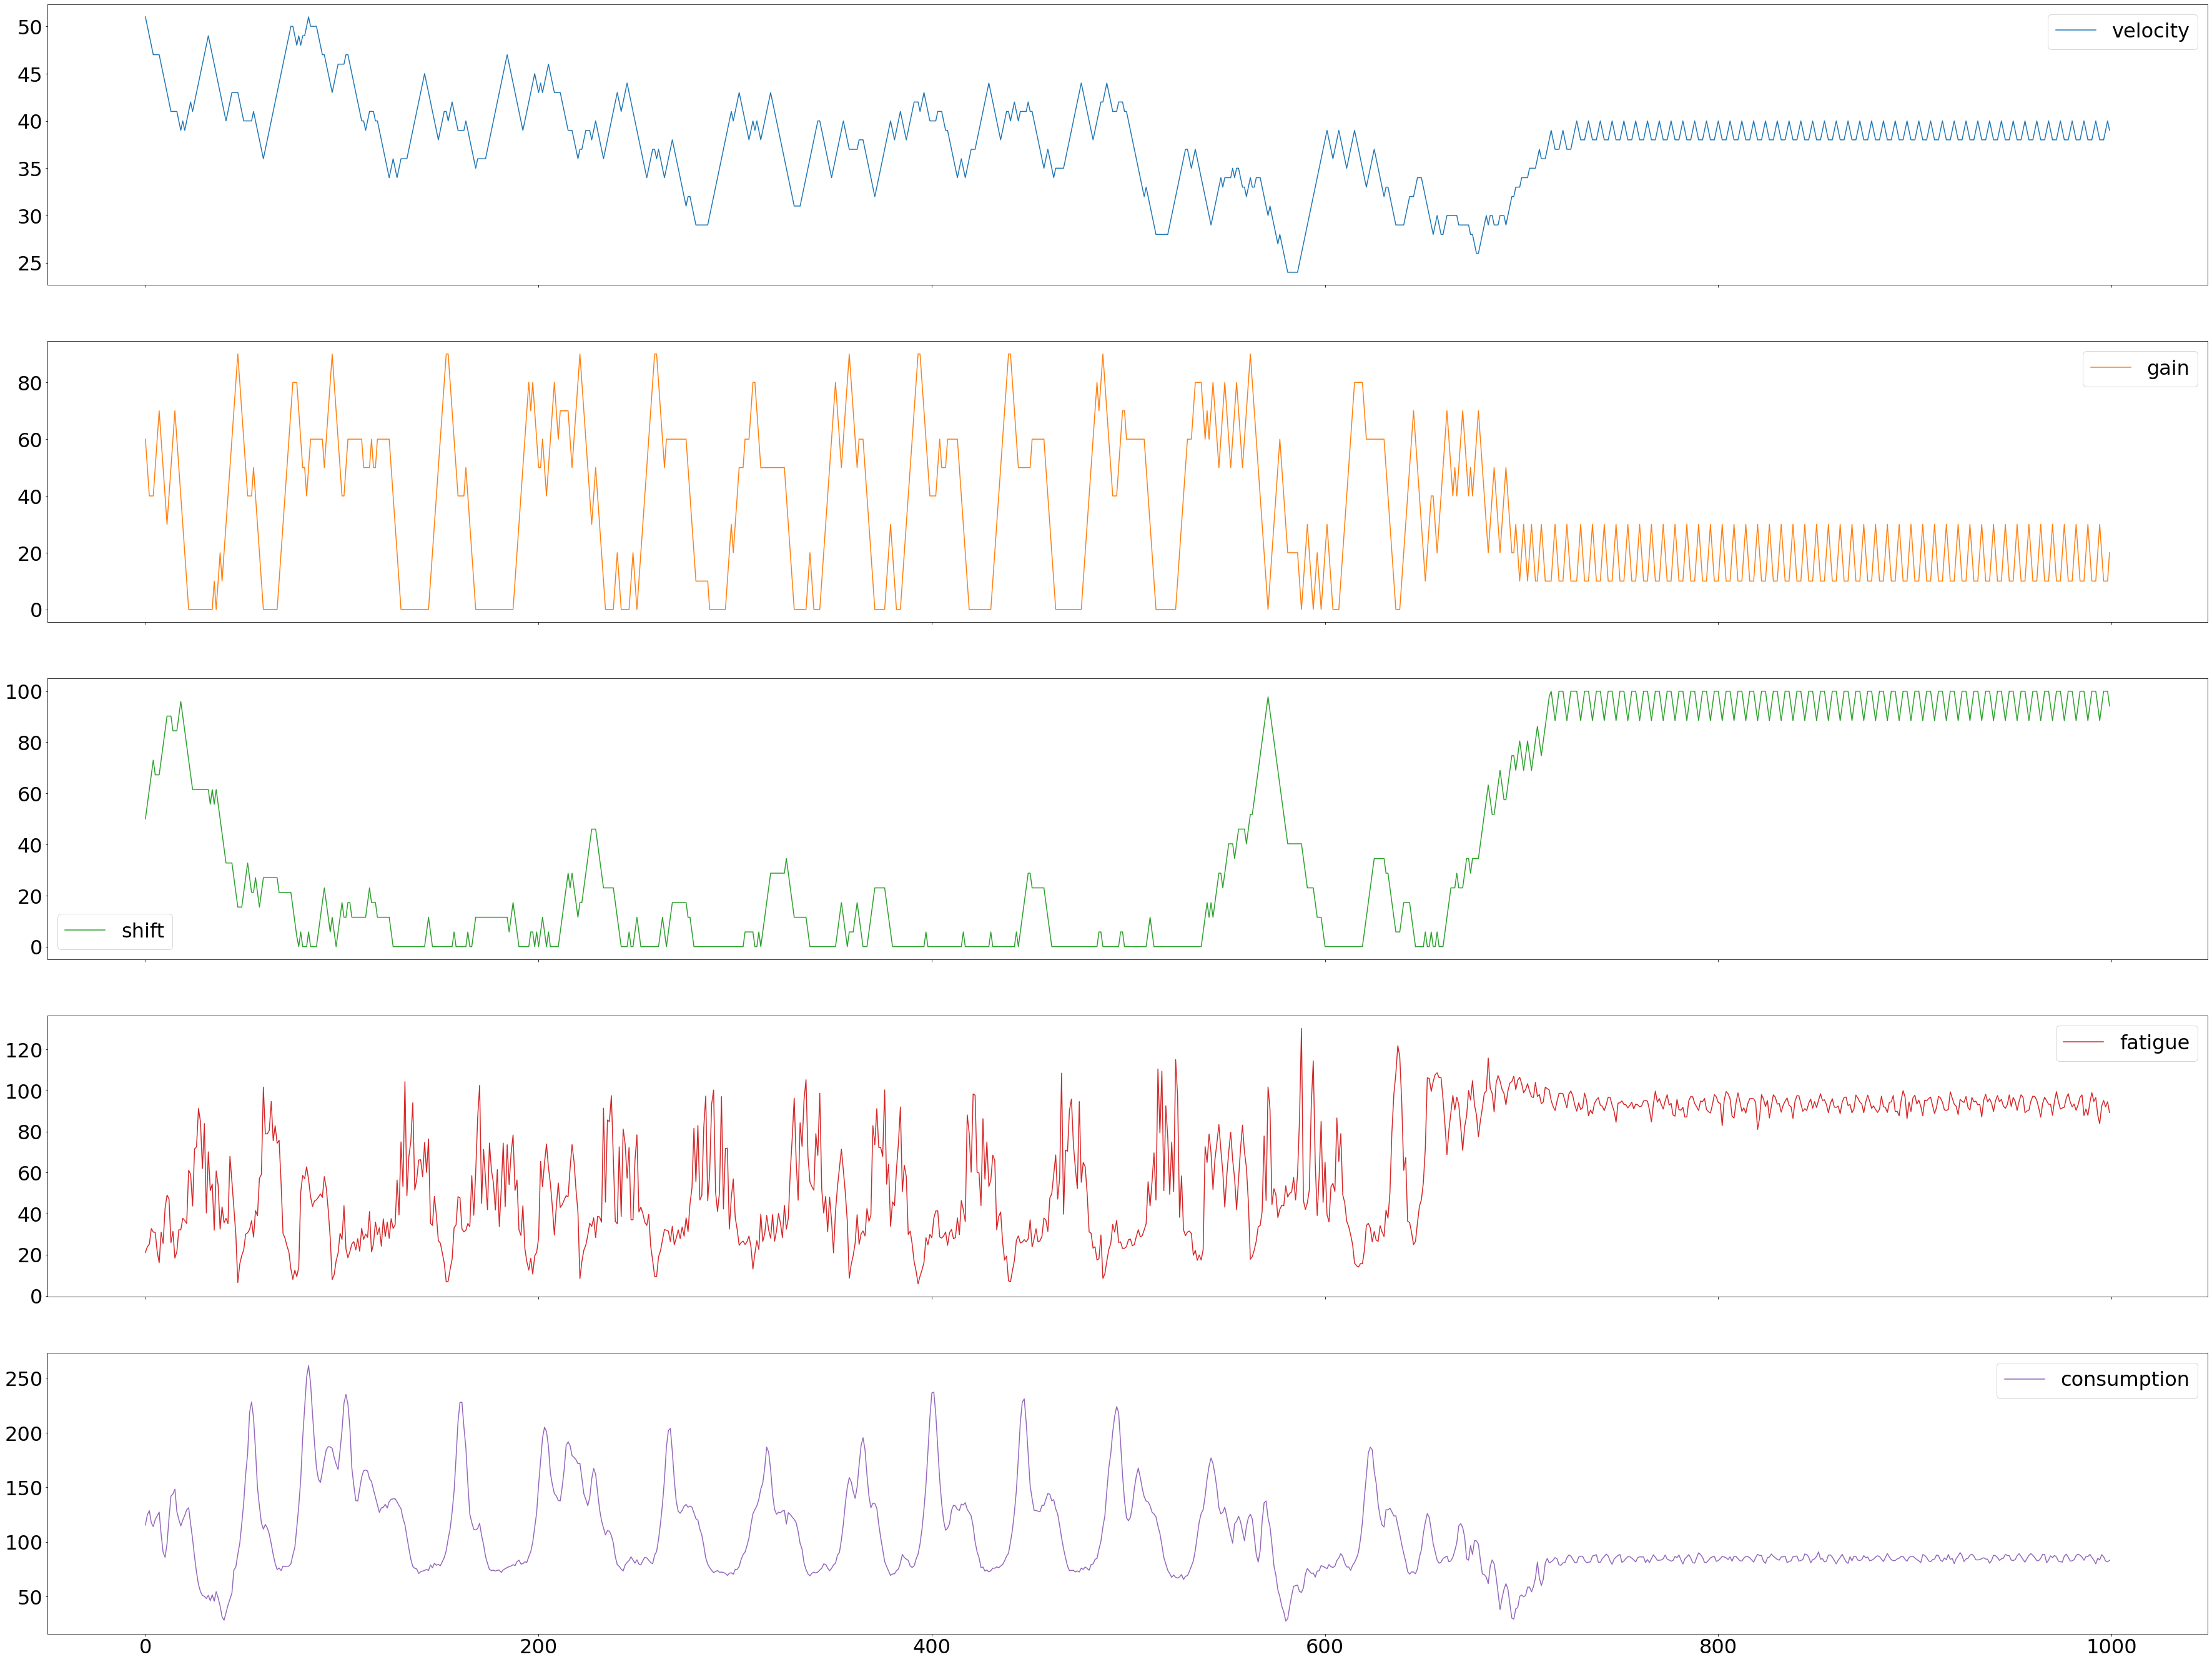

In [17]:
plot_industrial_benchmark_trajectories(policy_benchmarks.evaluators[-1].eval_trajectories[0]['info'])

In [18]:
df = pd.DataFrame(policy_benchmarks.benchmark_metrics)
df.T

,reward,std
ib_policy_trajectory_ep1000_model_final_h20bits3,-293.847227,32.711463
